In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['xception', 'imet-2019-fgvc6']


In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
WORKERS = 2
CHANNEL = 3
SIZE = 256
NUM_CLASSES = 1103
beta_f2=2

In [4]:
# Load dataset info
path_to_train = '../input/imet-2019-fgvc6/train/'
data = pd.read_csv('../input/imet-2019-fgvc6/train.csv')

train_dataset_info = []
for name, labels in zip(data['id'], data['attribute_ids'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [5]:
gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [6]:
def f2(y_true, y_pred):
    #y_pred = K.round(y_pred)
#     y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), F2_THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + K.epsilon())
    f2 = tf.where(tf.is_nan(f2), tf.zeros_like(f2), f2)
    return K.mean(f2)

In [7]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

class data_generator(Sequence):
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                    
                yield np.array(batch_images, np.float32), batch_labels

    def create_valid(dataset_info, batch_size, shape, augument=False):
        assert shape[2] == 3
        while True:
            # dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels


    def load_image(path, shape):
        image = cv2.imread(path+'.png')
        image = cv2.resize(image, (SIZE, SIZE))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=(-15,15)),
                iaa.Crop(px=(0, 16)),
                iaa.Affine(shear=(-5, 5)),
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Fliplr(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.applications import *
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [9]:
# reference link: https://gist.github.com/drscotthawley/d1818aabce8d1bf082a6fb37137473ae
from keras.callbacks import Callback

def get_1cycle_schedule(lr_max=1e-3, n_data_points=8000, epochs=200, batch_size=40, verbose=0):          
    """
    Creates a look-up table of learning rates for 1cycle schedule with cosine annealing
    See @sgugger's & @jeremyhoward's code in fastai library: https://github.com/fastai/fastai/blob/master/fastai/train.py
    Wrote this to use with my Keras and (non-fastai-)PyTorch codes.
    Note that in Keras, the LearningRateScheduler callback (https://keras.io/callbacks/#learningratescheduler) only operates once per epoch, not per batch
      So see below for Keras callback

    Keyword arguments:
    lr_max            chosen by user after lr_finder
    n_data_points     data points per epoch (e.g. size of training set)
    epochs            number of epochs
    batch_size        batch size
    Output:  
    lrs               look-up table of LR's, with length equal to total # of iterations
    Then you can use this in your PyTorch code by counting iteration number and setting
          optimizer.param_groups[0]['lr'] = lrs[iter_count]
    """
    if verbose > 0:
        print("Setting up 1Cycle LR schedule...")
    pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
    lr_start = lr_max/div_factor
    lr_end = lr_start/1e4
    n_iter = (n_data_points * epochs // batch_size) + 1    # number of iterations
    a1 = int(n_iter * pct_start)
    a2 = n_iter - a1

    # make look-up table
    lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
    lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
    lrs = np.concatenate((lrs_first, lrs_second))
    return lrs


class OneCycleScheduler(Callback):
    """My modification of Keras' Learning rate scheduler to do 1Cycle learning
       which increments per BATCH, not per epoch
    Keyword arguments
        **kwargs:  keyword arguments to pass to get_1cycle_schedule()
        Also, verbose: int. 0: quiet, 1: update messages.

    Sample usage (from my train.py):
        lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=X_train.shape[0],
        epochs=epochs, batch_size=batch_size, verbose=1)
    """
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s.' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.iteration = 0

In [13]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = Xception(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
#     x = Conv2D(32, kernel_size=(1,1), activation='relu')(base_model.output)
#     x = Flatten()(x)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [14]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
from sklearn.model_selection import train_test_split

epochs = 30; batch_size = 64
checkpoint = ModelCheckpoint('../working/xception_focal.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)


# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
train_generator_warmup = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=False)
validation_generator = data_generator.create_valid(
    train_dataset_info[valid_indexes], batch_size, (SIZE,SIZE,3), augument=False)

lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=len(train_indexes),
        epochs=1, batch_size=batch_size, verbose=0)
# callbacks_list = [checkpoint, csv_logger, lrsched]
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]

In [15]:
# warm up model
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True

model.compile(loss=focal_loss,
            # loss='binary_crossentropy',
              metrics=[f2],
    optimizer=Adam(1e-3))

# model.summary()

hist1 = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
#     validation_data=validation_generator,
#     validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=epochs,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1451/1451 [==============================] - 824s 568ms/step - loss: 5.3686 - f2: 0.0118
Epoch 2/30
1451/1451 [==============================] - 809s 557ms/step - loss: 4.2293 - f2: 0.0141
Epoch 3/30
1451/1451 [==============================] - 772s 532ms/step - loss: 4.1489 - f2: 0.0150
Epoch 4/30
1451/1451 [==============================] - 770s 531ms/step - loss: 4.2083 - f2: 0.0151
Epoch 5/30
1451/1451 [==============================] - 797s 550ms/step - loss: 4.1336 - f2: 0.0156
Epoch 6/30
1451/1451 [==============================] - 810s 559ms/step - loss: 4.1400 - f2: 0.0156
Epoch 7/30
1451/1451 [==============================] - 773s 533ms/step - loss: 4.0760 - f2: 0.0160
Epoch 8/30
1451/1451 [==============================] - 789s 543ms/step - loss: 4.1032 - f2: 0.0158
Epoch 9/30
1451/1451 [===============

In [16]:
# # train all layers
# for layer in model.layers:
#     layer.trainable = True

# model.compile(loss=focal_loss,
#             # loss='binary_crossentropy',
#               metrics=[f2],
#             optimizer=Adam(lr=1e-4))

# hist = model.fit_generator(
#     train_generator,
#     steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
#     validation_data=validation_generator,
#     validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
#     epochs=epochs,
#     verbose=1,
#     max_queue_size=16, workers=WORKERS, use_multiprocessing=True)

In [17]:
# fig, ax = plt.subplots(1, 2, figsize=(15,5))
# ax[0].set_title('loss')
# ax[0].plot(hist1.epoch, hist1.history["loss"], label="Train loss")
# # ax[0].plot(hist1.epoch, hist1.history["val_loss"], label="Validation loss")
# ax[1].set_title('f2')
# ax[1].plot(hist1.epoch, hist1.history["f2"], label="Train F2")
# # ax[1].plot(hist1.epoch, hist1.history["val_f2"], label="Validation F2")
# ax[0].legend()
# ax[1].legend()

In [18]:
print(os.listdir('../working/'))

['__notebook_source__.ipynb', '.ipynb_checkpoints']


In [19]:
# submit = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')
# model.load_weights('../working/xception_focal.h5')
# predicted = []

In [20]:
'''Search for the best threshold regarding the validation set'''

BATCH = 512
fullValGen = data_generator.create_valid(
    train_dataset_info[valid_indexes], BATCH, (SIZE,SIZE,3))

n_val = round(train_dataset_info.shape[0]*0.15)//BATCH
print(n_val)

lastFullValPred = np.empty((0, NUM_CLASSES))
lastFullValLabels = np.empty((0, NUM_CLASSES))
for i in tqdm(range(n_val+1)): 
    im, lbl = next(fullValGen)
    scores = model.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

  0%|          | 0/33 [00:00<?, ?it/s]

32


100%|██████████| 33/33 [03:16<00:00,  4.22s/it]

(16386, 1103) (16386, 1103)


In [21]:
def my_f2(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + 1e-15)

    return f2

def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in tqdm(thrs):
        score.append(my_f2(targs, (preds > thr).astype(int) ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


thr=0.260 F2=0.343


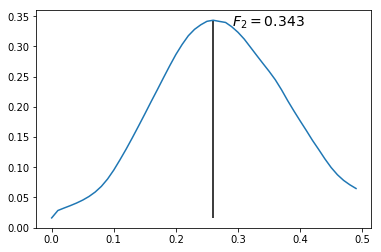

In [22]:
best_thr, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

In [23]:
for i, name in tqdm(enumerate(submit['id'])):
    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))
    score_predict = model.predict(image[np.newaxis]/255.)
    # print(score_predict)
    label_predict = np.arange(NUM_CLASSES)[score_predict[0]>=best_thr]
    # print(label_predict)
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

NameError: name 'submit' is not defined

In [ ]:
submit['attribute_ids'] = predicted
submit.to_csv('submission.csv', index=False)